In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    FSMOperator, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, 
    #FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, 
    #alarms_pareto, warnings_pareto, states_lines,
    #detect_edge_right, detect_edge_left, 
    cvset, load_data, get_cycle_data, get_cycle_data2, figures)
    
cred()
mp = MyPlant(0)
Engine._list_cached_validations();
#mp._fetch_installed_base(); # refresh local installed fleet database

In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[0]
modes = ['undefined','OFF','MAN','AUTO']
success = [True,False]
#success = [True]
e=Engine.from_fleet(mp,motor)
pp_from=e['Commissioning Date']
#pp_from='2022-03-28 06:00'
#pp_to='2022-03-28 08:14'
pp_to=datetime.now()
fsm = FSMOperator(e, p_from=pp_from, p_to=pp_to)
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('Forsa Hartmoor M01', ['undefined', 'OFF', 'MAN', 'AUTO'], [True, False])

In [4]:
fsm.run0(enforce=True, silent=False, debug=False)

FSM: 100%|███████████████████████| 10812/10812 [00:01<00:00, 8147.84 messages/s]


In [5]:
fsm.run1(silent=False, successtime=300, debug=False) # run Finite State Machine

FSM: 100%|███████████████████████| 10812/10812 [00:05<00:00, 2064.89 messages/s]


In [6]:
fsm.run2(silent = False)

FSM: 100%|█████████████████████████████| 179/179 [01:38<00:00,  1.82 messages/s]


In [7]:
fsm.store()
#TODO:
# - check in run1 & run2 if changes were made, if not ... do not physically change the stored file

In [8]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
rdb = rda
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")
pd.DataFrame.from_dict(e.dash, orient='index').T

Starts: 179, Successful: 97, Failed: 82 => 54.2%


,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M01,M01,AL87,624,H12,24,4495.0,24.5,1486144,159396,267.0,2022-01-10,63,204.0,None


In [9]:
#rda = rda[rda['count_alarms'] > 0]
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,False,undefined,102.47,4.24,22.68,61.0,,,190.39,,,,,,,0,0
1,1,True,undefined,93.11,4.14,20.57,6.25,54.96,126.92,305.95,4487.23,0.79,737.61,126.78,10.01,50.62,0,0
2,2,True,undefined,0.61,4.04,18.18,4.34,45.72,166.86,239.75,4490.57,0.6,3132.4,126.89,10.01,50.42,0,1
3,3,True,undefined,60.61,3.64,18.9,5.56,48.25,130.37,267.32,4513.0,0.77,14583.9,127.07,9.99,50.53,0,0
4,4,True,undefined,96.44,4.13,20.02,5.77,45.56,129.87,301.79,4504.94,0.77,2970.1,127.07,10.01,50.46,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,174,True,AUTO,98.36,3.74,20.61,4.55,5.35,146.64,279.26,4506.45,0.68,1176.82,126.63,9.99,51.18,0,0
175,175,True,AUTO,97.88,3.94,20.52,4.64,3.64,150.23,280.84,4517.62,0.67,4638.06,126.64,9.98,47.42,0,0
176,176,True,AUTO,97.55,3.83,20.07,4.55,3.64,150.1,279.73,4512.55,0.67,11810.85,126.55,9.99,47.46,0,1
177,177,True,AUTO,103.14,3.84,21.69,4.74,4.14,140.02,277.56,4499.08,0.71,3983.02,126.79,9.99,51.05,0,0


In [14]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(rde[vec].describe().round(2))
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-600,500), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,400)},
    {'col':['startpreparation'],'ylim':(-1000,800)},
    {'col':['hochlauf'],'_ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,6)},
    #{'col':['no'],'ylim':(-100,2000),'color':'rgba(0,0,0,0.3)'},
    {'col':['targetload'],'ylim':(500,5000) },
    {'col':['runout'],'ylim':(0,100) },
    {'col':['count_warnings','count_alarms','no'],'ylim':(-1,200), 'color':['rgba(255,165,0,0.3)','rgba(255,0,0,0.3)','rgba(0,0,0,0.1)'] }
    ]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,96.56,20.84,5.17,23.46,133.12,4501.35,0.79,283.07,7000.81,126.85,10.00,50.48
std,25.79,2.45,3.63,23.00,26.13,13.19,0.22,23.98,5944.33,0.16,0.03,0.94
min,0.61,8.06,4.04,1.21,49.34,4474.58,0.52,239.75,434.41,126.49,9.92,46.89
25%,96.44,19.37,4.44,5.05,127.85,4492.03,0.68,278.24,1855.27,126.76,9.99,50.44
50%,98.98,20.58,4.64,8.30,140.82,4499.47,0.71,279.04,5419.34,126.87,9.99,50.68
75%,101.70,22.70,4.84,44.27,146.90,4509.47,0.78,280.30,10820.34,126.94,10.00,50.94
max,285.65,27.04,40.07,95.90,190.60,4560.49,2.05,489.46,32521.01,127.28,10.09,51.36


In [ ]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')} CumStart: {startversuch['cumstarttime']:0.1f}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

In [ ]:
for f in figures:
    print(f, end=', ')
for doplot in ['actors','lubrication']:
#for doplot in ['actors']:
    dmaxlength = None
    dminlength = None
    #dmaxlength = 1200
    #dminlength = 200000
    dset = figures[doplot]
    vset = cvset(mp,dset)
    startversuch = rdb.iloc[vv]; 
    try:
        data = get_cycle_data2(fsm, startversuch, max_length=dmaxlength, min_length=dminlength, cycletime=1, silent=True, p_data=cvset(mp,dset))
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        fig = FSM_splot(fsm, startversuch, data, dset, figsize=(18,10))
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    except Exception as err:
        print(err)

In [ ]:
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show

#startversuch = rdb.iloc[vvv];
periodfactor = 3 # times calculated period length
helplinefactor = 0.8 # overlay slope to -fac * end value 
#interestingcycles = [0,1,8, 62, 65, 76, 77, 80, 95, 96, 97, 98, 99, 252, 678] # BMW Landshut M4
interestingcycles = [117] # Forsa Hartmoor M1
#interestingcycles = [0,64, 66, 82] # Forsa Hartmoor M4
#interestingcycles = [0] # Pforzheim M4
#interestingcycles = [17] #
#interestingcycles = [335] # !!! Bautzen M01 T902, Start von: 08.12.2021 13:14:29 bis: 12.12.2021 00:40:40
#interestingcycles = [142] # Bautzen M01 T902, Start von: 04.07.2021 15:57:29 bis: 04.07.2021 21:03:40  => Ende nicht erkannt. 
interestingcycles = [vv] # Bautzen M01 T902
disp_result(rdb.iloc[interestingcycles[0]])

In [ ]:
# Algorithm visualization
import time
import dmyplant2
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
for i in interestingcycles: 
    #startversuch=fsm.results['starts'][i]
    startversuch=rdb.iloc[i]
    sno = startversuch['no']
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch, periodfactor=periodfactor, helplinefactor=helplinefactor)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(16,8))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")

In [ ]:
sv=fsm.results['starts'][startversuch['no']]

#phases = [k for k in sv['startstoptiming''].keys() if k != 'targetoperation_org']
phases = list(sv['startstoptiming''].keys())
fsm._harvest_timings(sv, phases)
sv['loadramp']

In [ ]:
from pprint import pformat as pf
durations = { ph:pd.Timedelta(sv['startstoptiming''][ph][-1]['end'] - sv['startstoptiming''][ph][-1]['start']).total_seconds() for ph in phases}
#print(pf(durations))
durations['cumstarttime'] = sum([v for k,v in durations.items() if k in ['startpreparation','starter','speedup','idle','synchronize','loadramp']])
durations

In [ ]:
#pp(rdb.iloc[vv].to_dict())
sv;

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,179.00,144.00,138.00,137.00,131.00,131.00,131.00,179.00,105.00,105.00,105.00,105.00
mean,108.23,20.57,6.54,25.81,119.10,4061.08,0.83,239.89,6473.83,126.86,10.00,50.47
std,94.91,2.43,7.94,27.02,42.41,1062.82,0.27,123.68,6001.42,0.16,0.03,0.96
min,0.40,8.06,4.03,1.00,8.46,882.81,0.52,0.40,10.86,126.49,9.92,46.89
25%,78.27,18.57,4.47,5.14,99.86,4487.50,0.69,216.72,1820.62,126.76,9.99,50.46
50%,98.90,20.38,4.64,9.48,129.01,4498.97,0.77,278.39,4595.08,126.87,9.99,50.68
75%,103.86,22.60,5.55,45.56,144.70,4509.50,0.89,279.85,10031.31,126.96,10.00,50.94
max,828.72,27.04,61.00,117.26,190.77,4560.49,2.32,888.13,32521.01,127.28,10.09,51.36


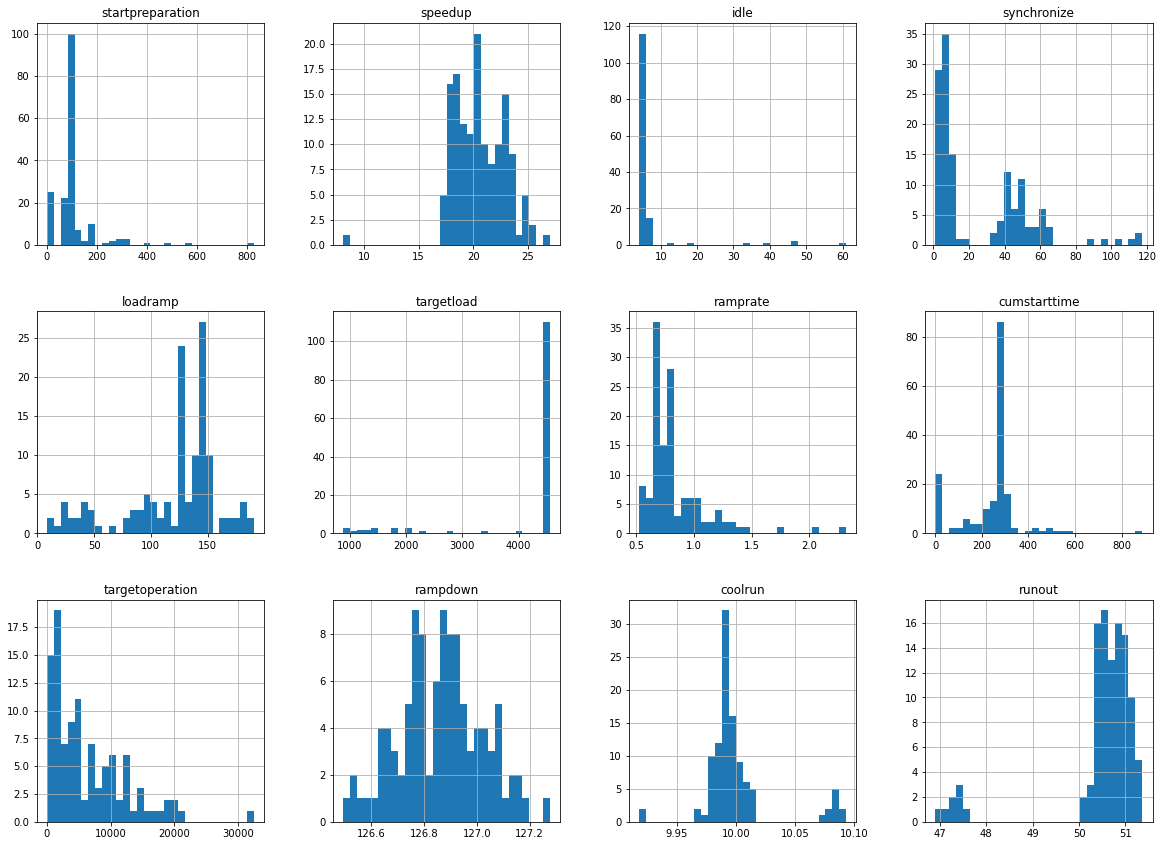

In [11]:
rdb = rda
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,layout=(4,4),figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [ ]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb[-3:].iterrows() : 
#for i, startversuch in tqdm(rdb.iterrows(), total=rdb.shape[0], ncols=80, mininterval=1, unit=' starts', desc="FSM Run2"):
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")    

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)